In [19]:
from dataloader import load_balanced_binary_dataset
import backend.src.utils.utils as utils

In [20]:
data = load_balanced_binary_dataset()
data = utils.clean_text(data, "text")

In [21]:
data

,sent_id,text,label
1211,602126-01-01,fremkalte følelser magi,1
4712,102329-06-01,forgjengeren slender the eight pages udiskutab...,1
3828,601300-02-03,helt rå,1
833,003283-16-03,kanskje heller fungert filmen,1
512,201734-24-01,prioriterer batteritid framfor best ytelse mas...,1
...,...,...,...
742,003480-11-01,litt anonym helt,0
868,102138-10-03,heller sikker kvalitetstegn stemme graven bite...,0
4452,004773-10-01,gjentar flere ganger filmen møter ulike ansatt...,0
3924,201344-23-01,kjensgjerning smartklokker alltid enkle leve p...,0


<AxesSubplot:>

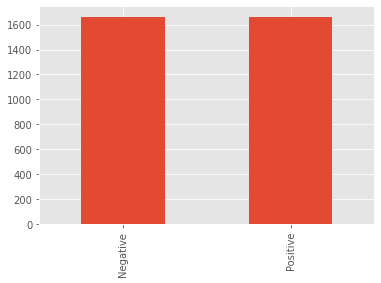

In [22]:
data["label"].replace({0: "Negative", 1: "Positive"}).value_counts().sort_index().plot.bar()

<AxesSubplot:ylabel='Frequency'>

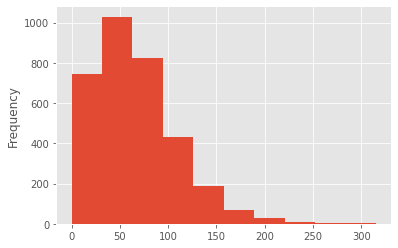

In [23]:
data["text"].str.len().plot.hist()

In [24]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras_preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(data["text"], data["label"], test_size=0.1, random_state=42, shuffle=True)

tokenizer = Tokenizer(num_words=20000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [25]:
from random import randint

random_idx = randint(0, len(X_train))
review_label_mapping = {0: "Negative", 1: "Positive"}
review_label = review_label_mapping[int(y_train.iloc[random_idx])]

print(f"Review {random_idx} contains {len(X_train[random_idx])} words and is {review_label}")
print("Review content:", end="\n\n")
print(" ".join(tokenizer.index_word[idx] for idx in X_train[random_idx]))

Review 29 contains 3 words and is Positive
Review content:

fremkalte følelser magi


In [26]:
from collections import Counter

word_counter = Counter()
for review in X_train:
    for word in review:
        word_counter[tokenizer.index_word[word]] += 1

In [27]:
word_counter.most_common(10)

[('litt', 148),
 ('godt', 104),
 ('får', 99),
 ('gjør', 93),
 ('helt', 90),
 ('filmen', 89),
 ('nok', 83),
 ('the', 83),
 ('første', 77),
 ('to', 70)]

In [28]:
maxlen = 100

X_train = pad_sequences(X_train, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)

In [29]:
import numpy as np

y_train = np.array(y_train)
y_test = np.array(y_test)

In [30]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (2993, 100)
X_test shape: (333, 100)


In [31]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

model = Sequential()
model.add(Embedding(20000, 128))
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.3))
model.add(Dense(1, activation='sigmoid'))

In [32]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 128)         2560000   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2,691,713
Trainable params: 2,691,713
Non-trainable params: 0
_________________________________________________________________


In [33]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor="val_accuracy", mode="max", patience=3)

epochs = 20
batch_size = 16
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=1,
                    callbacks=[early_stop])

Epoch 1/20
150/150 [==============================] - 25s 151ms/step - loss: 0.6899 - accuracy: 0.5251 - val_loss: 0.6797 - val_accuracy: 0.6027
Epoch 2/20
150/150 [==============================] - 27s 180ms/step - loss: 0.4586 - accuracy: 0.8083 - val_loss: 0.6829 - val_accuracy: 0.6210
Epoch 3/20
150/150 [==============================] - 31s 206ms/step - loss: 0.1270 - accuracy: 0.9607 - val_loss: 0.9359 - val_accuracy: 0.6260
Epoch 4/20
150/150 [==============================] - 32s 216ms/step - loss: 0.0451 - accuracy: 0.9866 - val_loss: 1.0488 - val_accuracy: 0.6210
Epoch 5/20
150/150 [==============================] - 32s 216ms/step - loss: 0.0165 - accuracy: 0.9967 - val_loss: 1.3245 - val_accuracy: 0.6260
Epoch 6/20
150/150 [==============================] - 32s 215ms/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 1.4383 - val_accuracy: 0.6244


In [34]:
from datetime import datetime

model.save(f"models/SA-LSTM-BINARY-BALANCED-{datetime.now().strftime('%Y%m%d%H%M%S')}.h5")

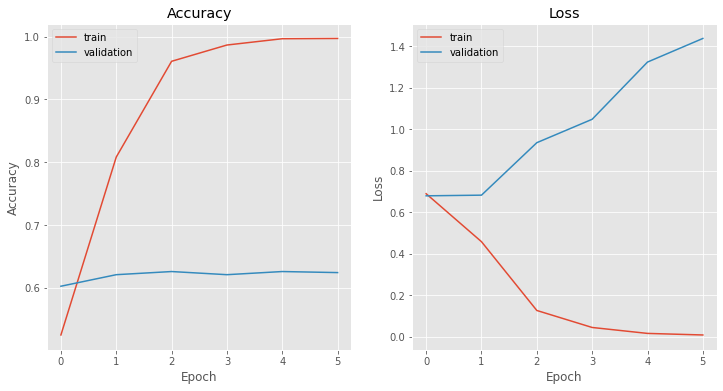

In [35]:
from backend.src.utils.utils import plot_history

plot_history(history)

In [36]:
# Evaluation
val_loss, val_acc = model.evaluate(X_test, y_test)
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

11/11 [==============================] - 0s 35ms/step - loss: 1.4730 - accuracy: 0.6036
Validation loss: 1.4730472564697266
Validation accuracy: 0.6036036014556885
